### 心电分类标准(AAMI)

1.AAMI EC57标准简介
ANSL／AAMI EC57：2012 是由美国医疗仪器促进协会(Association for the Advancement of Medical Instrumentation，AAMI)制定的一系列标准，包括心率失常的分类、心律失常分类检测算法的评估标准等等。

AAMI规定心电节拍可以分为五大类：
- N(正常或者束支传导阻滞节拍)
- s(室上性异常节拍)
- V(心室异常节拍)
- F(融合节拍)
- Q(未能分类的节拍)
以及无法识读的u类、辅助无法识读标志的x类和0类

AAMI还规定了心律失常分类检测算法的评估标准，包括算法准确率的计算方法（混淆矩阵），以及准确率(Acc)、灵敏度(sen)、真阳性率(Ppr)等作为衡量分类器分类性能的参数。通过混淆矩阵计算各个参数。

AAMI标准中指出Q类分类的准确率仅供参考，而u、x、0类不是真正的心电节拍，因此最终衡量分类算法的准确率是N、s、V、F类的心电节拍的Acc、Sen、Ppr。

2.为什么要应用AAMI标准
规范化，便于横向比较
目前发表的关于心电信号自动分类的论文中，有很大一部分没有应用AAMI标准，而是任意选取5-9个MIT-BIH中数量最多的心拍种类进行分类，导致无法科学有效地横向比较各个算法的优劣，这是当前心电分类领域存在的一个很严重的问题。如果相关研究人员都能应用AAMI标准下的分类标准和评估标准，并且统一使用MIT-BIH中同样的数据作为实验数据，各个算法的横向比较将变得容易很多。

3.MIT-BIH数据库的心拍类型 vs AAMI规定的心电种类
AAMI规定的心电种类和MIT- BIH 心电数据库注释的心拍类型是两种临床上的分类方法，因此需要把MIT- BIH 数据库注释的心电节拍类型转换为AAMI的心电种类，转换表格如下
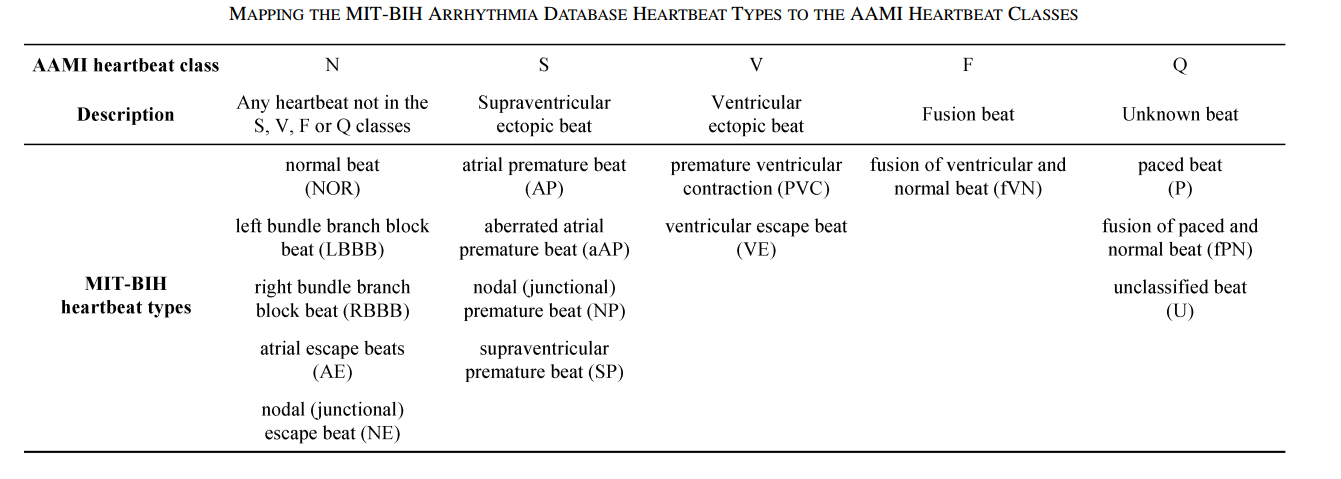

原文链接：https://blog.csdn.net/amilylwy/article/details/53446143

### 将Mit数据集中的19类心拍标签转化为AAMI中的五类

1.原因:以上是所查阅资料的原因,以下是小组经过思考所得的:
(1)AAMI分类仅有五类,而Mit数据集中的心拍标签却有19类之多,做深度学习肯定分的类别越少,最终预测的结果也就越准确
(2)和以上资料所说的一样,AAMI分类比Mit数据集分类的普适性高,使用程度高

In [1]:
import wfdb
import numpy as np
import csv

AAMI_MIT  = {'N': 'Nfe/jnBLR',#将19类信号分为五大类
             'S': 'SAJa',
             'V': 'VEr',
             'F': 'F',
             'Q': 'Q?'}
# 5分类存储字典
AAMI = {'N': [],'S': [],'V': [],'F': [], 'Q': []}
file_name =['100', '101', '102', '103', '104', '105', '106', '107',
            '108', '109', '111', '112', '113', '114', '115', '116',
            '117', '118', '119', '121', '122', '123', '124', '200',
            '201', '202', '203', '205', '207', '208', '209', '210',
            '212', '213', '214', '215', '217', '219', '220', '221',
            '222', '223', '228', '230', '231', '232', '233', '234']
ECG = {'N': [], 'f': [], 'e': [], '/': [], 'j': [], 'n': [], 'B': [],
       'L': [], 'R': [], 'S': [], 'A': [], 'J': [], 'a': [], 'V': [],
       'E': [], 'r': [], 'F': [], 'Q': [], '?': []}

for F_name in file_name:
    signal_annotation = wfdb.rdann(f'../Datasets/mit-bih-arrhythmia-database-1.0.0/{F_name}', \
                                   "atr", sampfrom=0, sampto=650000)
    record = wfdb.rdrecord(f'..\Datasets\mit-bih-arrhythmia-database-1.0.0/{F_name}',\
                            sampfrom=0, sampto=650000, physical=True, channels=[0, ])
    # 删除非R点的标签
    ECG_R_list = np.array(['N', 'f', 'e', '/', 'j', 'n', 'B',
                           'L', 'R', 'S', 'A', 'J', 'a', 'V',
                           'E', 'r', 'F', 'Q', '?'])
    # 获取表示R点的心拍类型的索引
    Index = np.isin(signal_annotation.symbol, ECG_R_list)
    # 将标签从list列表类型转化为数组类型为了用下面的索引值提取
    Label = np.array(signal_annotation.symbol)
    # 提取表示为R点的心拍标签
    Label = Label[Index]
    # 提取表示为R点的坐标
    Sample = signal_annotation.sample[Index]
    # 获取心拍种类
    Label_kind = list(set(Label))
    # 读取每一种R点在信号中的位置
    for k in Label_kind:
        index = [i for i, x in enumerate(Label) if x == k]
        Signal_index = Sample[index]
        length = len(record.p_signal)
        #print(Signal_index)
        #截取
        for site in Signal_index:
            if 130 < site < length-130:
                ECG_signal = record.p_signal.flatten().tolist()[site-130:site+130]
                #print(ECG_signal)
                ECG[str(k)].append(ECG_signal)

# 打印种类
for key, value in ECG.items():
    print(f'{key} = {len(value)}')

for ECG_key, ECG_value in ECG.items():
    for AAMI_MIT_key, AAMI_MIT_value in AAMI_MIT.items():
        if ECG_key in AAMI_MIT_value:
            AAMI[AAMI_MIT_key].extend(ECG_value)

# 5分类并保存到CSV格式的文件里
for key, value in AAMI.items():
    with open(f'./AAMI/{key}.csv', 'w',newline='\n') as f:
        writer = csv.writer(f)
        # 将列表的每条数据依次写入csv文件， 并以逗号分隔
        # 传入的数据为列表中嵌套列表或元组，每一个列表或元组为每一行的数据
        writer.writerows(value)

                


N = 75021
f = 982
e = 16
/ = 7025
j = 229
n = 0
B = 0
L = 8071
R = 7256
S = 2
A = 2546
J = 83
a = 150
V = 7129
E = 106
r = 0
F = 802
Q = 33
? = 0


In [ ]:
import csv
import numpy as np

AAMI_key = {'N','S','V','F','Q'}
AAMI = dict()

def Tolist(x):
    return list(map(float,x))

for key in AAMI_key:
    with open(f'{key}.csv', 'r') as f:
        reader = csv.reader(f)
        AAMI[key] = list(map(Tolist,list(reader)))

for i in AAMI_key:
    print(f'{i}={np.array(AAMI[i]).shape}')

### 将五类心电滤波后存入新的文件夹

In [1]:
import pandas as pd

f1 = pd.read_csv("F.csv")
f2 = pd.read_csv("N.csv")
f3 = pd.read_csv("Q.csv")
f4 = pd.read_csv("S.csv")
f5 = pd.read_csv("V.csv")

In [3]:
from scipy import signal
import numpy as np

def butterwoth_fliter(data, frequency=360, highpass=40, lowpass=0.1):
    [b, a] = signal.butter(3, [lowpass / frequency * 2, highpass / frequency * 2], 'bandpass')
    Signal_pro = signal.filtfilt(b, a, data)
    return Signal_pro

filter_F = np.zeros(f1.shape)
filter_N = np.zeros(f2.shape)
filter_Q = np.zeros(f3.shape)
filter_S = np.zeros(f4.shape)
filter_V = np.zeros(f5.shape)

for i in range(0,f1.shape[0]):
    fliter_ecg = butterwoth_fliter(f1.iloc[i])#滤波
    filter_F[i] = fliter_ecg
for i in range(0,f2.shape[0]):
    fliter_ecg = butterwoth_fliter(f2.iloc[i])#滤波
    filter_N[i] = fliter_ecg
for i in range(0,f3.shape[0]):
    fliter_ecg = butterwoth_fliter(f3.iloc[i])#滤波
    filter_Q[i] = fliter_ecg
for i in range(0,f4.shape[0]):
    fliter_ecg = butterwoth_fliter(f4.iloc[i])#滤波
    filter_S[i] = fliter_ecg
for i in range(0,f5.shape[0]):
    fliter_ecg = butterwoth_fliter(f5.iloc[i])#滤波
    filter_V[i] = fliter_ecg


In [19]:
import csv
# for key in AAMI_key:
with open(f'./filtered_butterworth/F_filter.csv', 'w',newline='\n') as f: #./filered_butterworth/F_filter.csv
    writer = csv.writer(f)
    # 将列表的每条数据依次写入csv文件， 并以逗号分隔
    # 传入的数据为列表中嵌套列表或元组，每一个列表或元组为每一行的数据
    writer.writerows(filter_F)
with open(f'./filtered_butterworth/N_filter.csv', 'w',newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(filter_N)
with open(f'./filtered_butterworth/Q_filter.csv', 'w',newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(filter_Q)
with open(f'./filtered_butterworth/S_filter.csv', 'w',newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(filter_S)
with open(f'./filtered_butterworth/V_filter.csv', 'w',newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(filter_V)

### Mit数据集读取并进行预处理

In [ ]:
import pywt
import matplotlib.pyplot as plt

# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

record = wfdb.rdrecord('../Datasets/mit-bih-arrhythmia-database-1.0.0/' + '100', channel_names=['MLII'])
data = record.p_signal.flatten()
rdata = denoise(data=data)
# 获取心电数据记录中R波的位置和对应的标签
annotation = wfdb.rdann('../Datasets/mit-bih-arrhythmia-database-1.0.0/' + '100', 'atr')
Rlocation = annotation.sample
Rclass = annotation.symbol
plt.plot(data[:3600])
plt.plot(rdata[:3600])
Rlocation_1 = Rlocation[Rlocation <= 3600]
plt.plot(Rlocation_1,data[:3600][Rlocation_1],'ro')
print(Rclass)
print(Rlocation)
# print(Rclass)

In [22]:
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# 测试集在数据集中所占的比例
RATIO = 0.2

# 读取滤波后的心电数据和对应标签
numberSet = ['F_filter','N_filter','Q_filter','S_filter','V_filter']
# numberSet_test = ['F_filter1']
lableSet = []
dataSet_last = np.empty((0,260))
# lableSet = ['F','N','Q','S','V']
for i in numberSet:
    dataSet = pd.read_csv('./filtered_butterworth/{}.csv'.format(i)).to_numpy()
    for j in range(0,dataSet.shape[0]):
        lableSet.append(numberSet.index(i))
    dataSet = np.concatenate((dataSet,dataSet_last),axis=0)
    dataSet_last = dataSet
lableSet = np.array(lableSet).reshape(-1,1)
train_ds = np.hstack((dataSet, lableSet))
np.random.shuffle(train_ds)
# 数据集及其标签集
X = train_ds[:, :260].reshape(-1, 260, 1)
Y = train_ds[:, 260]
# 测试集及其标签集
shuffle_index = np.random.permutation(len(X))
# 设定测试集的大小 RATIO是测试集在数据集中所占的比例
test_length = int(RATIO * len(shuffle_index))
# 测试集的长度
test_index = shuffle_index[:test_length]
# 训练集的长度
train_index = shuffle_index[test_length:]
X_test, Y_test = X[test_index], Y[test_index]
X_train, Y_train = X[train_index], Y[train_index]


In [23]:
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

(21888, 260, 1)
(87553, 260, 1)
(21888,)
(87553,)


In [24]:
# 构建CNN模型
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(260, 1)),# 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='tanh'),# 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),# 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),# 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),# 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='tanh'),# 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'), # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),# 打平层,方便全连接层处理'
        tf.keras.layers.Flatten(),# 全连接层,128 个节点 转换成128个节点
        tf.keras.layers.Dense(128, activation='relu'),# Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),# 全连接层,5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


def main():
    # X_train,Y_train为所有的数据集和标签集
    # X_test,Y_test为拆分的测试集和标签集
    # X_train, Y_train, X_test, Y_test = loadData()
    print(X_train.shape)

    model = buildModel()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy']
                  # metrics: 列表，包含评估模型在训练和测试时的性能的指标，典型用法是metrics=[‘accuracy’]。
                  )
    model.summary()

    # 训练与验证
    model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=RATIO)  # validation_split 训练集所占比例
    
    # 预测
    Y_pred = model.predict(X_test)
    print(Y_pred)

    model.save(r'./model/Five_classifications.h5')

if __name__ == '__main__':
    main()

(87553, 260, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 260, 4)            88        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 130, 4)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 130, 16)           1488      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 65, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 65, 32)            12832     
                                                                 
 average_pooling1d (AverageP  (None, 33,

In [27]:
# 0.9931
# tensorflow有毒,加载模型不能存放在中文路径下面
model = tf.keras.models.load_model('./model/Five_classifications.h5')
model1 = model.predict(X_test)

684/684 [==============================] - 4s 6ms/step


(21888, 5)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
21888
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1

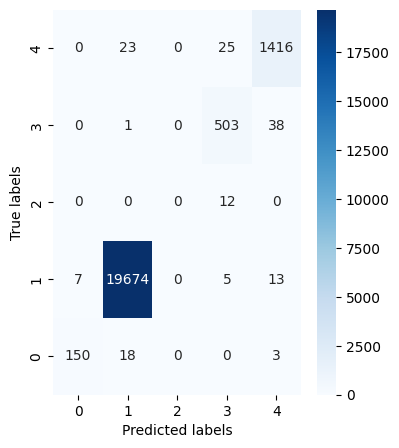

array([[  150,    18,     0,     0,     3],
       [    7, 19674,     0,     5,    13],
       [    0,     0,     0,    12,     0],
       [    0,     1,     0,   503,    38],
       [    0,    23,     0,    25,  1416]], dtype=int64)

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras.utils import to_categorical

def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 绘图
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
print(model1.shape)
# print(X_test.shape)
# plotHeatMap(Y_test, model1)
# X_test.shape

one_hot_preds = keras.utils.to_categorical(model1.argmax(axis=1), num_classes=5)
print(one_hot_preds)

# categories = 5 # 类别数目
# # 创建单位矩阵，并获取对应行
# one_hot_matrix = np.eye(categories)
# one_hot_data = one_hot_matrix[Y_test]
# print(one_hot_data)
one_hots = to_categorical(Y_test)
one_hots
data = [np.argmax(one_hot)for one_hot in one_hots]
data_pre = [np.argmax(one_hot)for one_hot in one_hot_preds]
print(len(Y_test))
print(data_pre)
plotHeatMap(data,data_pre)
confusion_matrix(data, data_pre)